In [3]:
import numpy as np
import copy
import pickle

from scipy import ndimage
from BaselineRemoval import BaselineRemoval
import matplotlib.pyplot as plt
import os
from scipy import interpolate
from scipy import signal
from scipy.fft import fft, ifft, fftfreq
import pywt
from math import *

plt.rcParams['figure.figsize'] = (20.0, 10.0)
# plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['figure.dpi'] = 500
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

Gregory R. Lee, Ralf Gommers, Filip Wasilewski, Kai Wohlfahrt, Aaron O’Leary (2019). PyWavelets: 

A Python package for wavelet analysis. Journal of Open Source Software, 4(36), 1237, 

https://doi.org/10.21105/joss.01237.

In [4]:

# plt.rcParams['figure.figsize'] = (25.0, 5.0)
# plt.rcParams['figure.dpi'] = 50

for family in pywt.families():
    for name in pywt.wavelist(family):
        print(name, end='\t')
#         try:
#             w = np.array(pywt.Wavelet(name).filter_bank)
#         except:
#             continue
#         for i in range(4):
#             plt.plot(w[i])
#         plt.show()


haar	db1	db2	db3	db4	db5	db6	db7	db8	db9	db10	db11	db12	db13	db14	db15	db16	db17	db18	db19	db20	db21	db22	db23	db24	db25	db26	db27	db28	db29	db30	db31	db32	db33	db34	db35	db36	db37	db38	sym2	sym3	sym4	sym5	sym6	sym7	sym8	sym9	sym10	sym11	sym12	sym13	sym14	sym15	sym16	sym17	sym18	sym19	sym20	coif1	coif2	coif3	coif4	coif5	coif6	coif7	coif8	coif9	coif10	coif11	coif12	coif13	coif14	coif15	coif16	coif17	bior1.1	bior1.3	bior1.5	bior2.2	bior2.4	bior2.6	bior2.8	bior3.1	bior3.3	bior3.5	bior3.7	bior3.9	bior4.4	bior5.5	bior6.8	rbio1.1	rbio1.3	rbio1.5	rbio2.2	rbio2.4	rbio2.6	rbio2.8	rbio3.1	rbio3.3	rbio3.5	rbio3.7	rbio3.9	rbio4.4	rbio5.5	rbio6.8	dmey	gaus1	gaus2	gaus3	gaus4	gaus5	gaus6	gaus7	gaus8	mexh	morl	cgau1	cgau2	cgau3	cgau4	cgau5	cgau6	cgau7	cgau8	shan	fbsp	cmor	

In [5]:
file_location = "../data/Raman_Mouse/corrected_4_wavenumbers/"
# file_location = "../data/Green_excitation/corrected_4_wavenumbers/"

filenames = np.load(f"{file_location}FileNames.npy")
with open(f"{'/'.join(file_location.split('/')[:-2])}/Sample_labels.pickle", 'rb') as f:
    labels = pickle.load(f)
labels = {l.split(".")[0]: val for l, val in labels.items()}

wavenumbers = np.load(f"{file_location}Wavenumbers.npy")
    
data = []
for f in filenames:
    x = np.load(f"{file_location}{f.split('.')[0]}.npy")
    data.append(((x.reshape(-1,x.shape[-1])).reshape(x.shape), labels[f.split(".")[0]]))

In [8]:
def gaussian(x, mu, sigma, scale):
    x = scale * np.exp(-0.5* ((x - mu) / sigma)**2)
    return x 

def split_signal(x):
    x = img[0].reshape(-1, img[0].shape[-1])
    n = np.random.randint(x.shape[0])
    n = 85
    
    x_ = copy.copy(x[n])
    x_ -= np.mean(x_)
    
    widths = np.logspace(0, 3, 301)
    
    cwtmatr, freq = pywt.cwt(x_, widths, wavelet='gaus4')
    print(1/freq)
    PSD = (cwtmatr * np.conj(cwtmatr)).real
    R, I = cwtmatr.real, cwtmatr.imag
    plt.imshow(np.log(PSD), aspect='auto', vmax=np.log(PSD.max()), vmin=0)
    plt.show()
    plt.imshow(PSD, aspect='auto', vmax=PSD.max(), vmin=0)
    plt.show()
    plt.imshow(np.log(np.abs(R)), aspect='auto', vmax=np.log(R.max()), vmin=0)
    plt.show()
    plt.imshow(np.log(np.abs(I)), aspect='auto', vmax=np.log(I.max()), vmin=0)
    plt.show()

[   2.            2.04658598    2.0942571     2.14303861    2.19295639
    2.24403691    2.29630724    2.34979511    2.40452887    2.46053754
    2.51785082    2.5764991     2.63651348    2.69792577    2.76076853
    2.82507509    2.89087954    2.95821678    3.0271225     3.09763324
    3.16978638    3.24362019    3.31917381    3.3964873     3.47560166
    3.55655882    3.63940172    3.72417427    3.81092144    3.8996892
    3.99052463    4.08347589    4.17859226    4.27592418    4.37552325
    4.47744228    4.58173531    4.68845763    4.79766584    4.90941783
    5.02377286    5.14079157    5.26053598    5.38306961    5.50845741
    5.63676586    5.76806301    5.90241845    6.03990344    6.18059087
    6.32455532    6.47187314    6.62262243    6.77688312    6.93473701
    7.09626778    7.2615611     7.43070458    7.60378793    7.7809029
    7.96214341    8.14760556    8.33738767    8.53159038    8.73031664
    8.93367184    9.14176379    9.35470283    9.57260185    9.79557639
   10.02

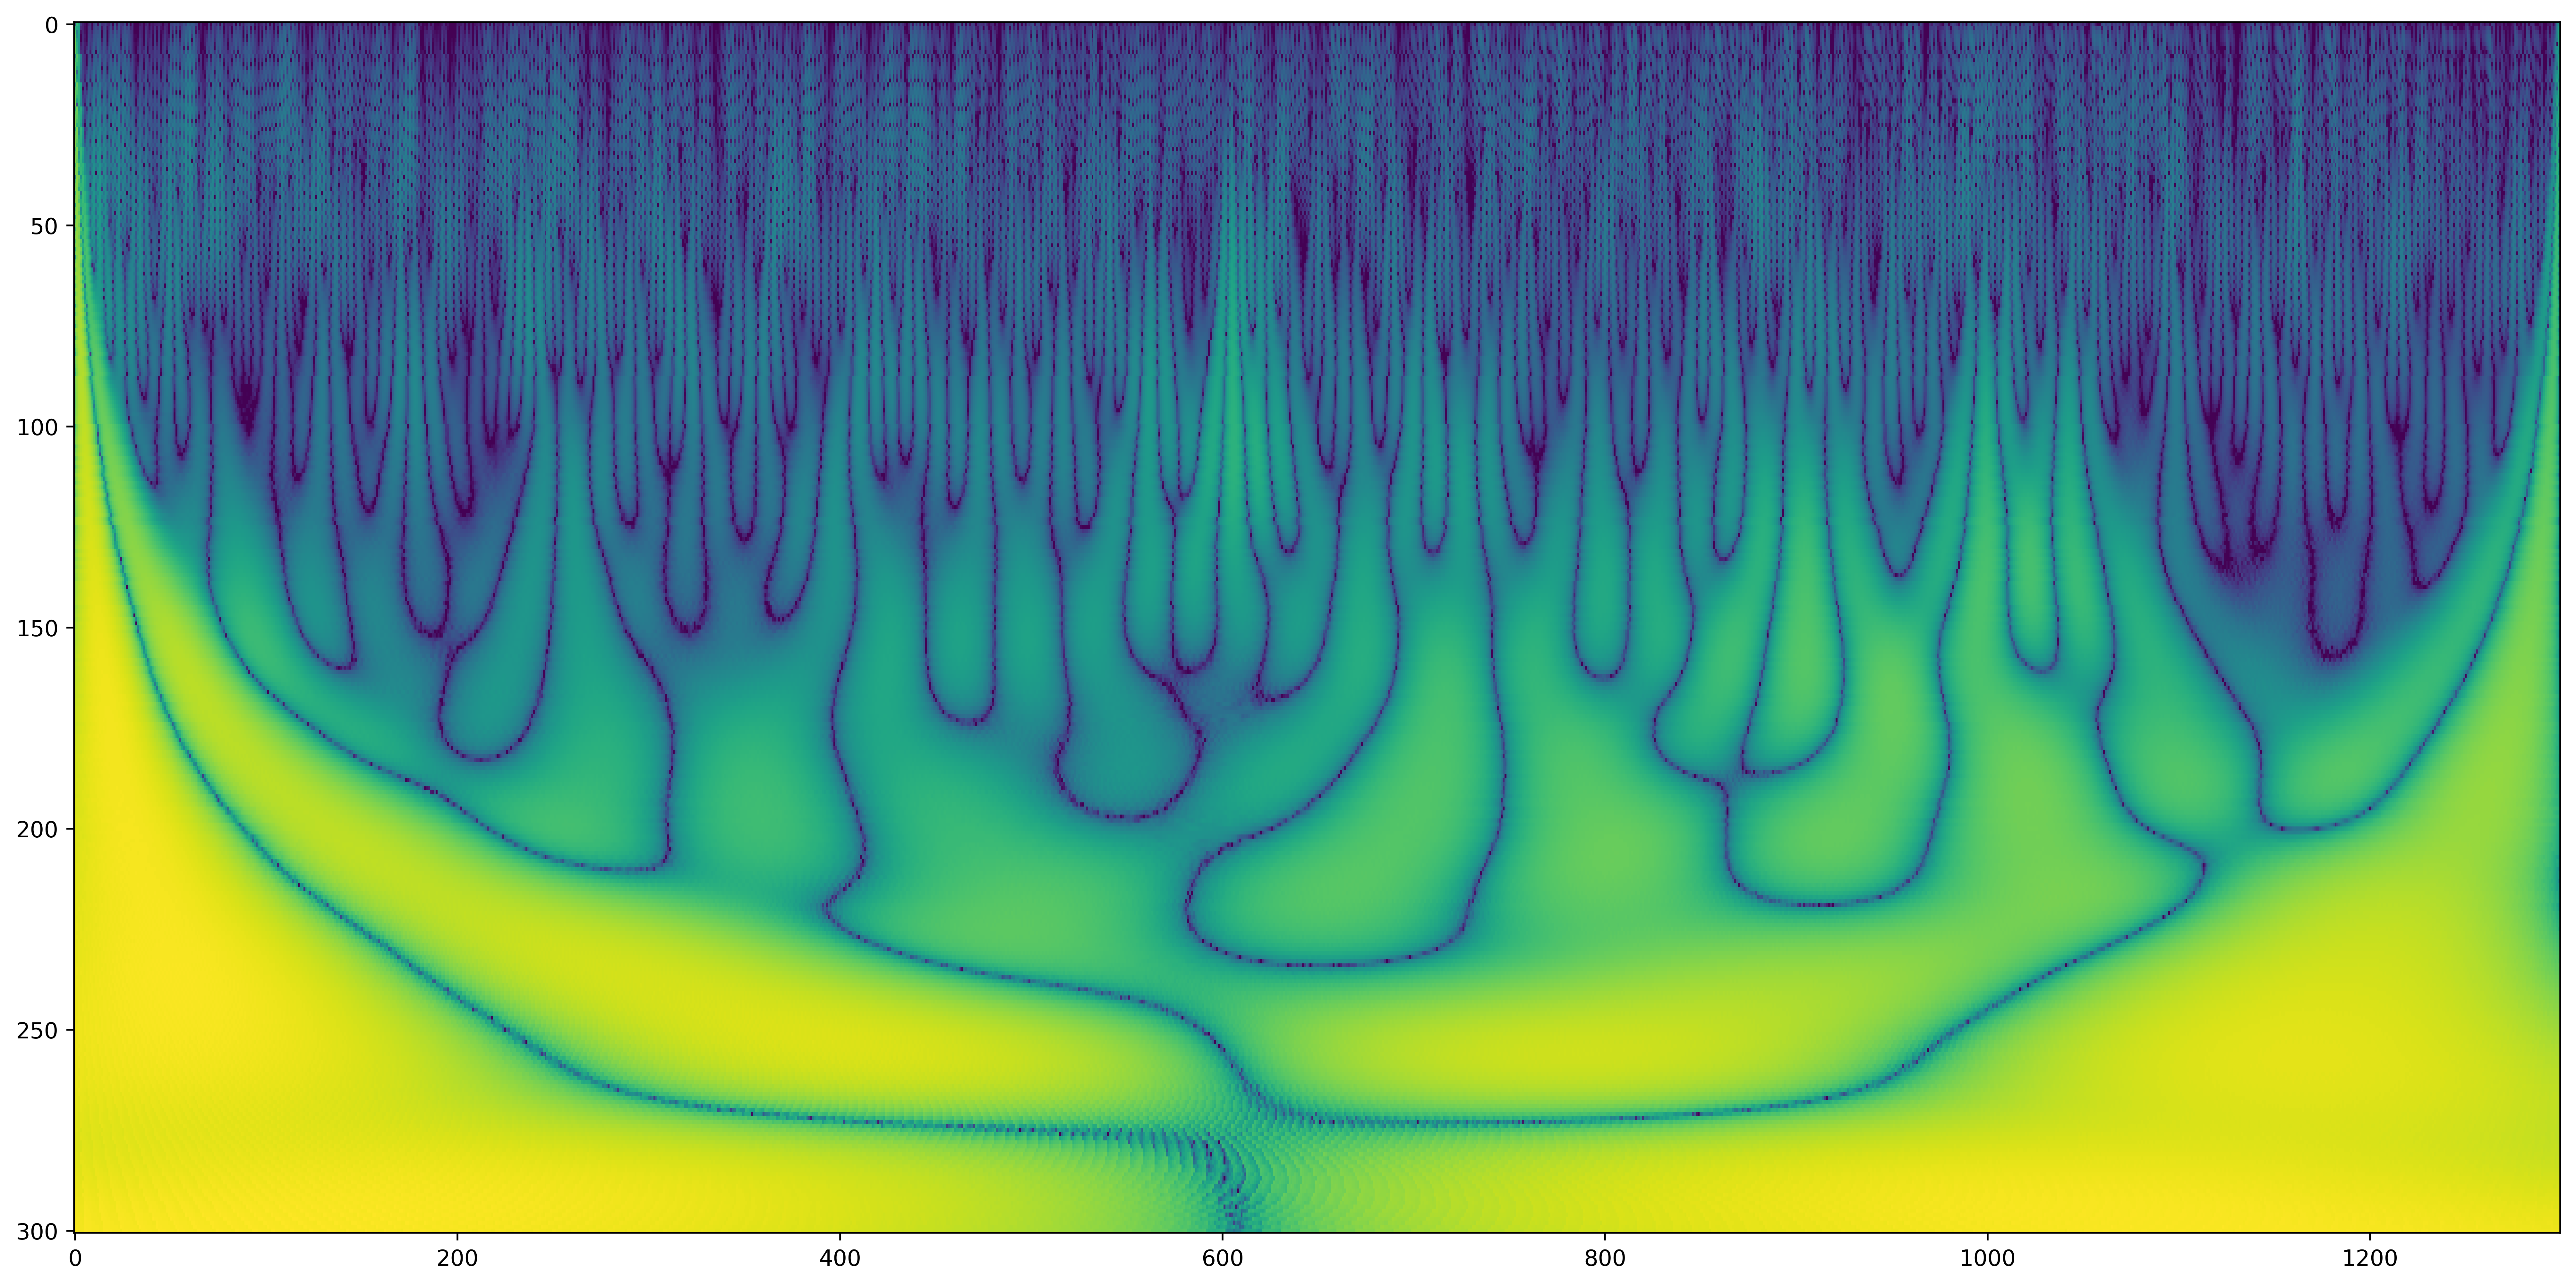

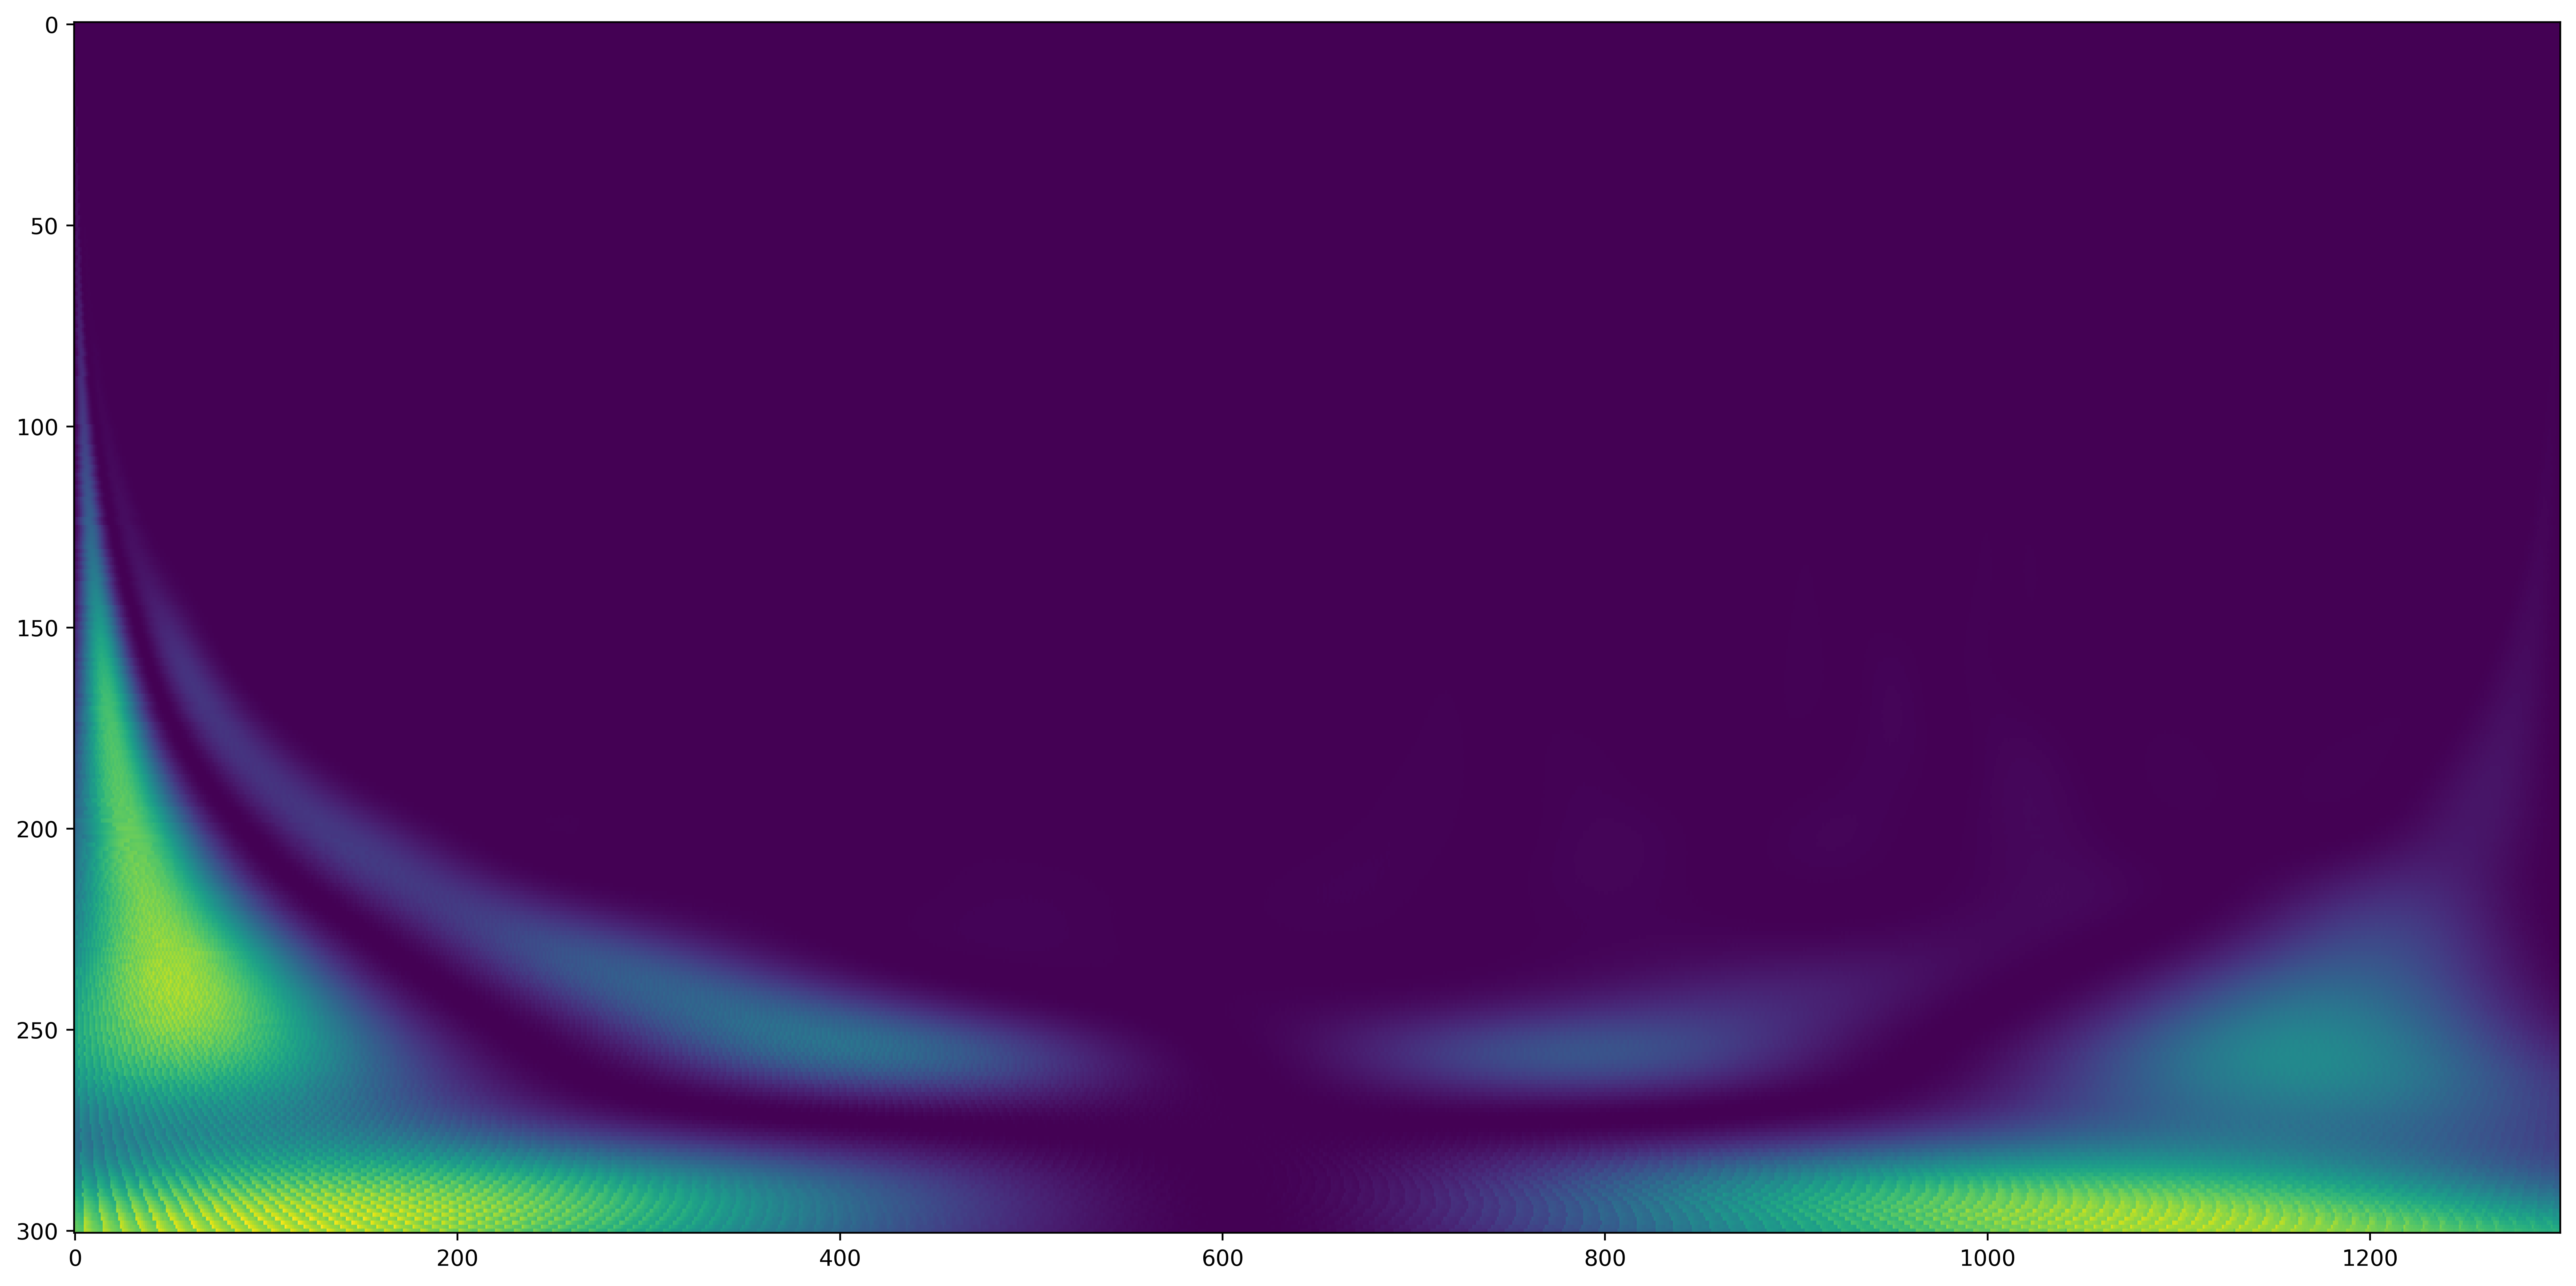

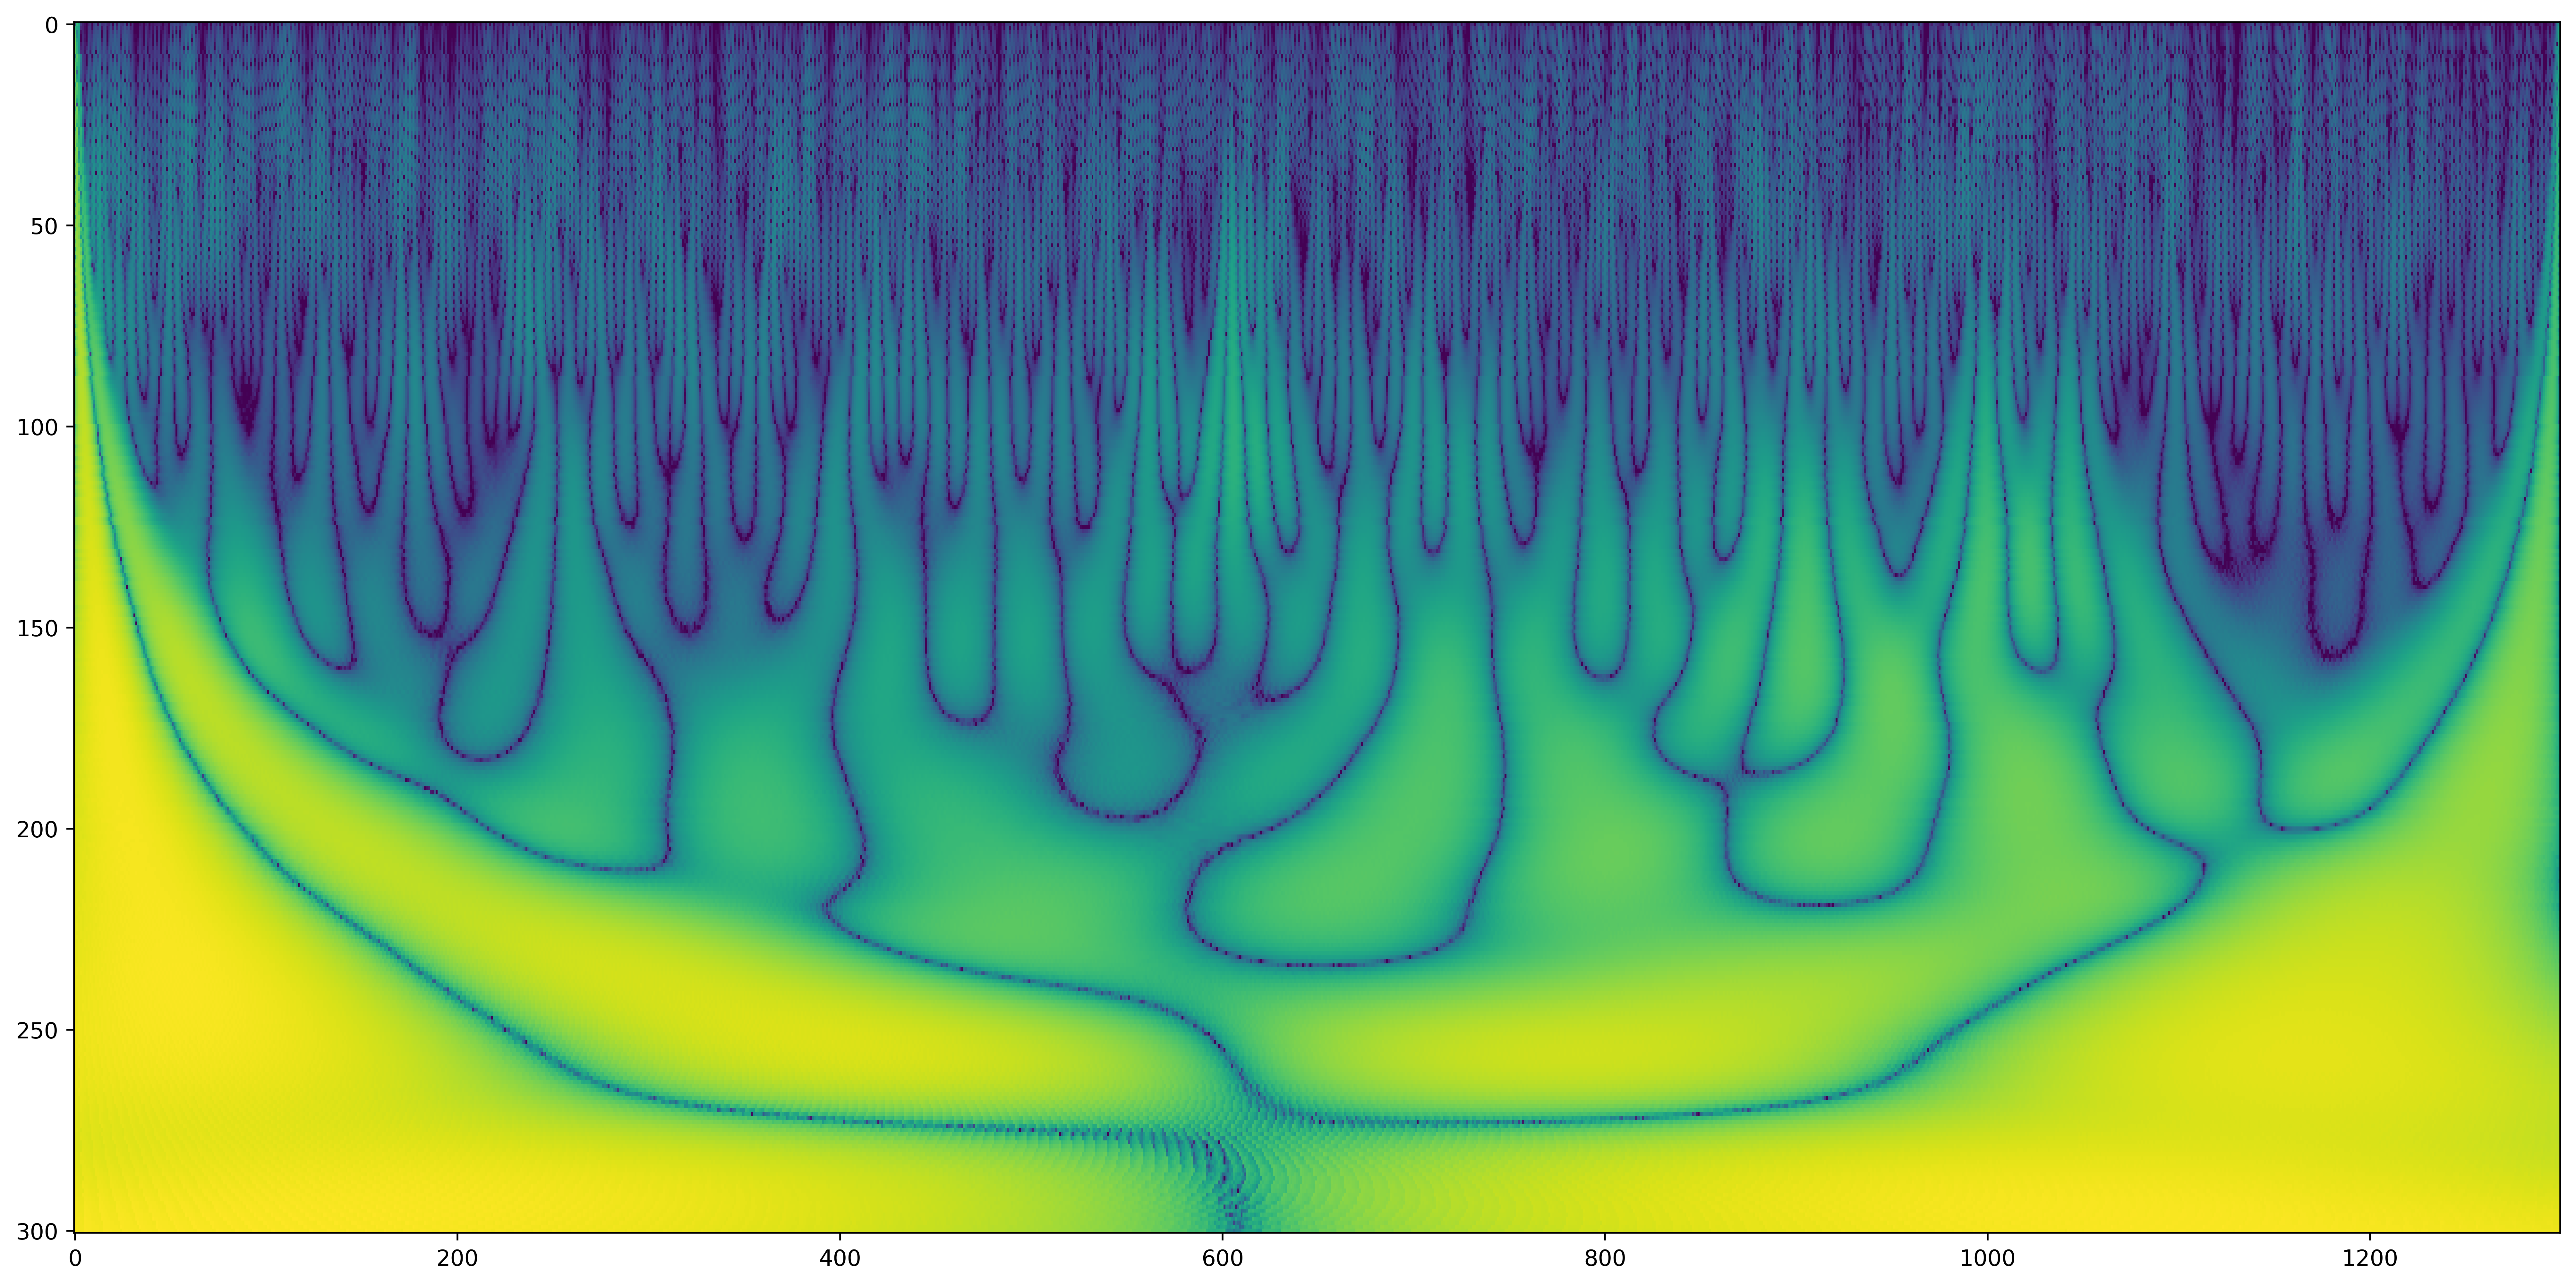

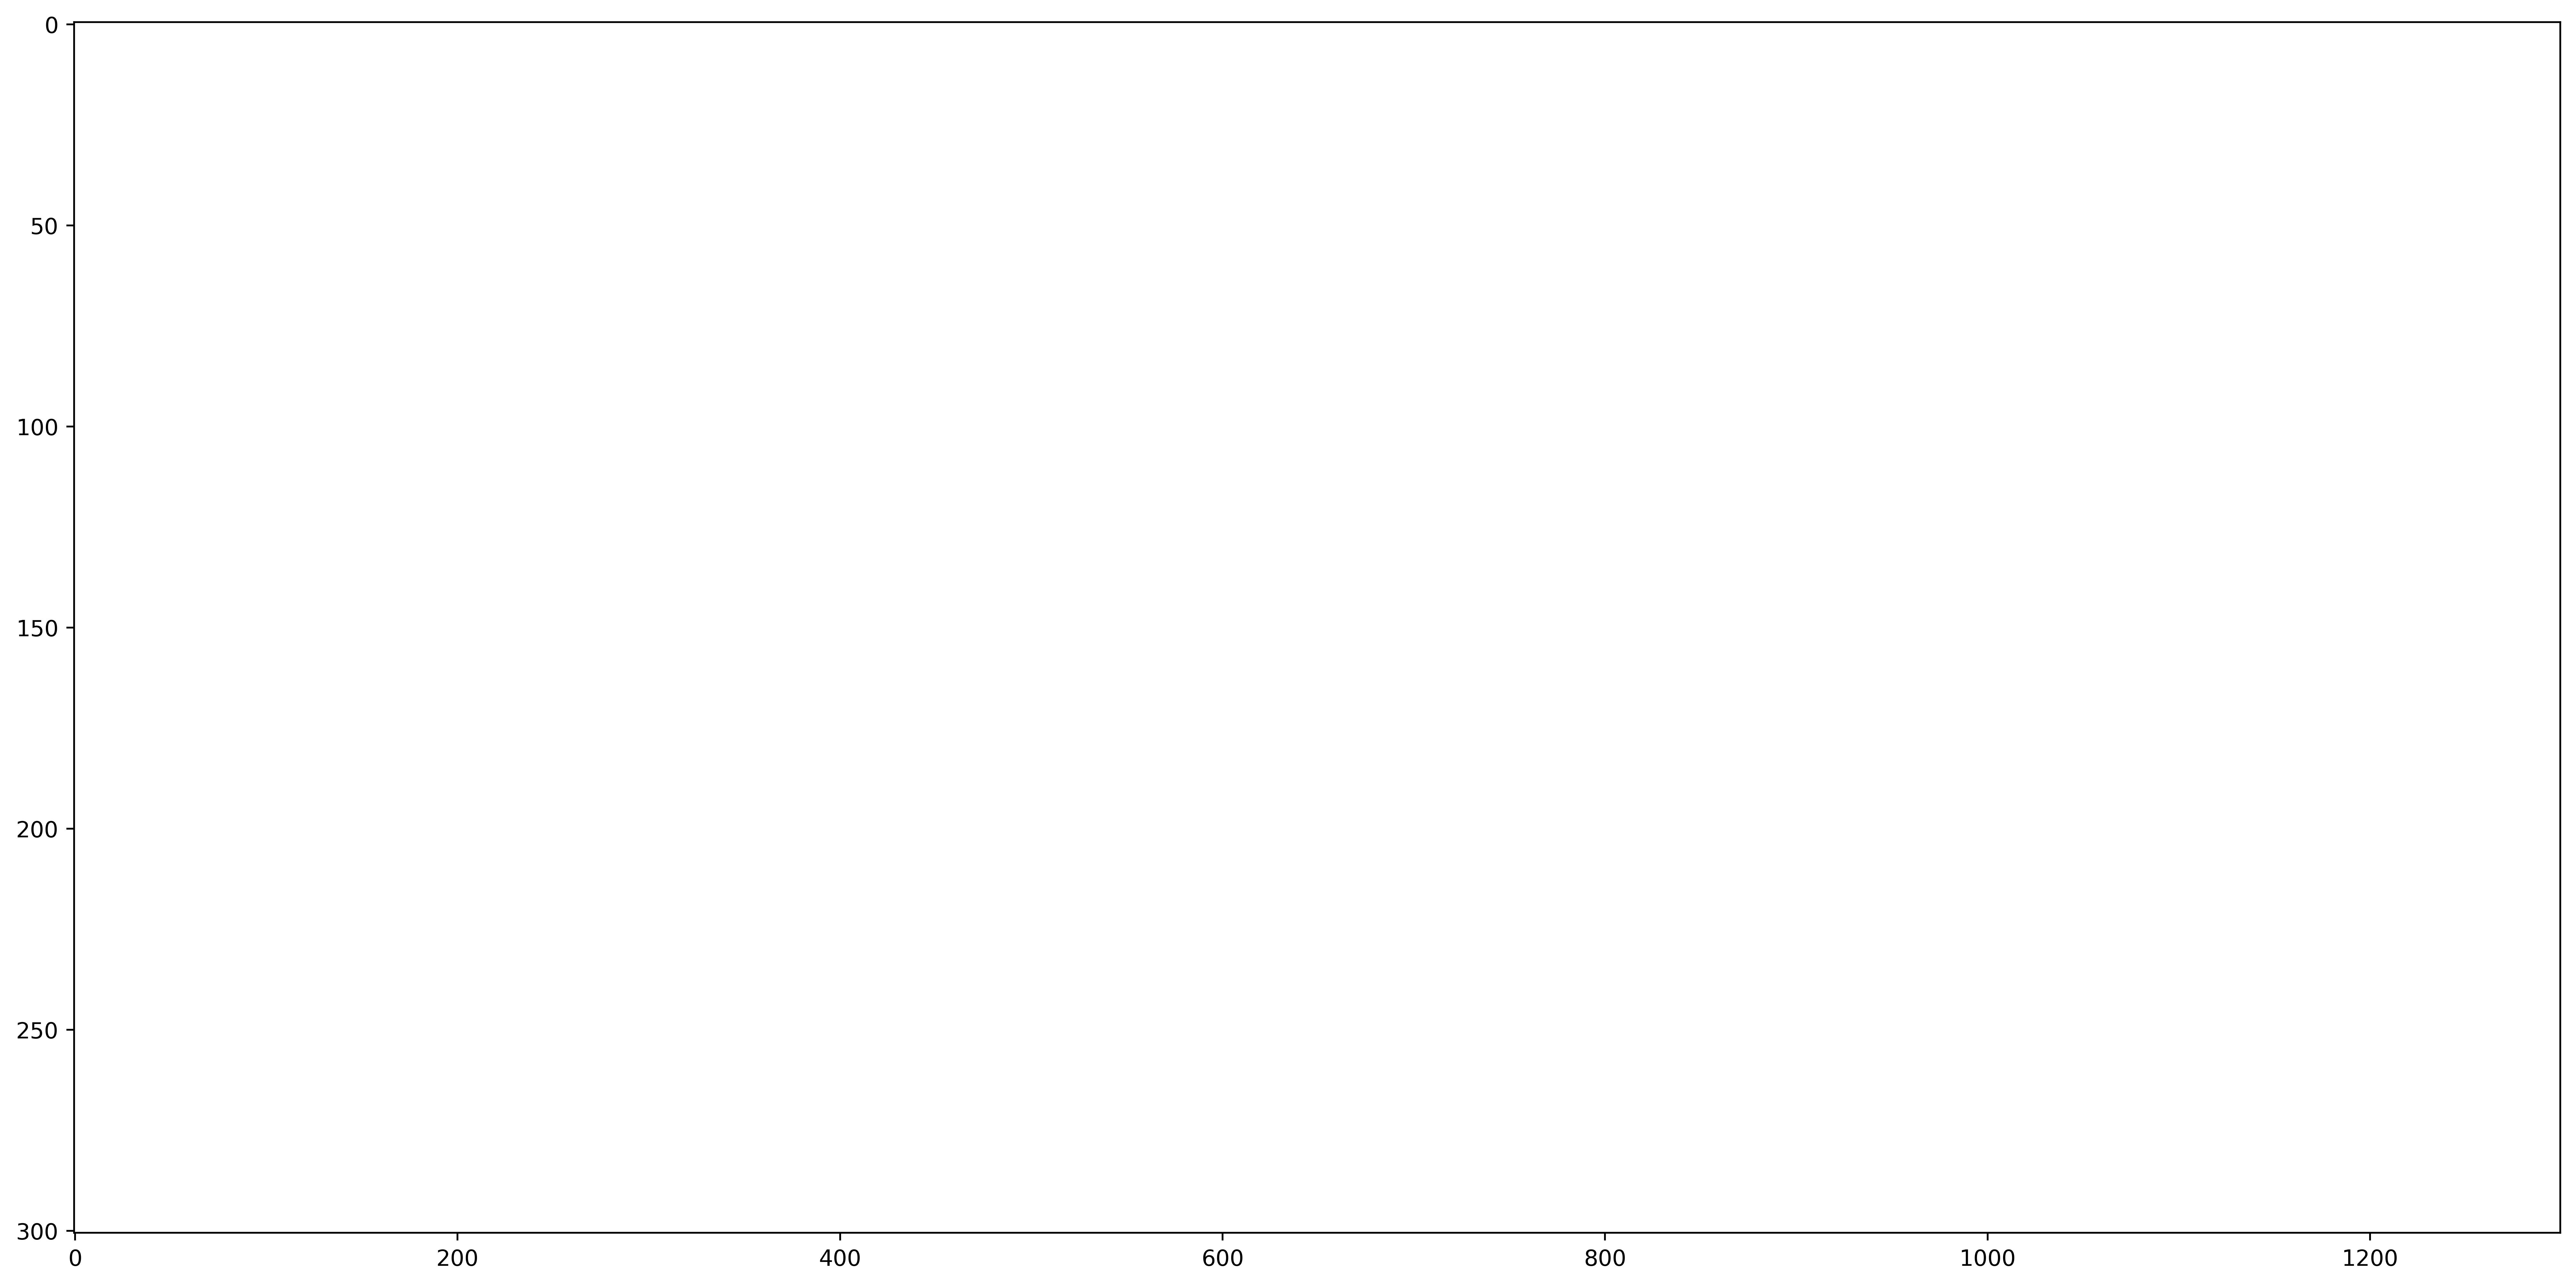

TypeError: cannot unpack non-iterable NoneType object

In [9]:
import timeit
from os import path

file_location2 = f"{'/'.join(file_location.split('/')[:-2])}/approximated/"
os.makedirs(file_location2, exist_ok=True)

shape = data[0][0].shape

for j, (f, img) in enumerate(zip(filenames, data)):   
    start = timeit.default_timer()
#     if path.exists(f'{file_location2}{f.split("/")[-1].split(".")[0]}_raman.npy'):
#         print(f'file already exist {file_location2}{f.split("/")[-1].split(".")[0]}_raman')
#         continue

#     if j < 7:
#         continue
    
    raman, photo = split_signal(img)

    stop = timeit.default_timer()
    print('Time: ', stop - start)  

    np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_raman', raman.reshape(shape))
    np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_photoluminescence', photo.reshape(shape))
    print(f"image: {f} is done.")